# Anomaly Detection – Unsupervised Failure Detection

Goal: use unsupervised anomaly detection to identify unusual machine operating
conditions based only on sensor and operational features. The model does not
see failure labels during training; they are used later only for evaluation.

This setup mirrors real-world scenarios where failures are rare and labels
may be delayed, incomplete, or noisy.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix, classification_report


In [2]:
df = pd.read_csv('/Users/mykael/ml-fundamentals/data/predictive_maintenance.csv')
df.head()
df.columns

Index(['UDI', 'Product ID', 'Type', 'Air temperature [K]',
       'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]',
       'Tool wear [min]', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF',
       'RNF'],
      dtype='object')

In [ ]:
X = df.drop(columns=['UDI','Product ID','TWF', 'HDF', 'PWF', 'OSF', 'RNF', 'Machine failure']) #labels for the model
y = df['Machine failure'] #going to be used later in evaluation of the model

X = pd.get_dummies(X, columns=["Type"], drop_first=True)
X.head()

df["Machine failure"].value_counts(normalize=True)



Machine failure
0    0.9661
1    0.0339
Name: proportion, dtype: float64

The Isolation Forest assigns an anomaly score to each observation. We binarize
its output into predicted anomalies (1) and normal points (0) to compare
against the true `Machine failure` labels.


In [ ]:
X_train = X[y == 0]  # Use only normal data for training
X_train.shape, X.shape # Check the shape of training and full data telling us how many failure data points we have

iso = IsolationForest(n_estimators=200,contamination=0.03,random_state=42) #0.03 is 3% of failures in data (checked above)

iso.fit(X_train)

y_pred_iso = iso.predict(X)#predict on all data(raw predictions)
y_anom = np.where(y_pred_iso == -1, 1, 0) # Map to 0/1: 1 = normal -> 0, -1 = anomaly -> 1 cos label = -1 is anomaly and 1 is normal

pd.Series(y_anom).value_counts()



0    9653
1     347
Name: count, dtype: int64

In [8]:
print("Confusion Matrix (Isolation Forest vs Machine failure):")
print(confusion_matrix(y, y_anom))

print("\nClassification Report:")
print(classification_report(y, y_anom, digits=3))


Confusion Matrix (Isolation Forest vs Machine failure):
[[9371  290]
 [ 282   57]]

Classification Report:
              precision    recall  f1-score   support

           0      0.971     0.970     0.970      9661
           1      0.164     0.168     0.166       339

    accuracy                          0.943     10000
   macro avg      0.568     0.569     0.568     10000
weighted avg      0.943     0.943     0.943     10000



The Isolation Forest model successfully learned normal operating behavior and identified a subset of anomalous conditions. However, only a fraction of actual failures were flagged as anomalies, highlighting that not all failures are statistically abnormal. This confirms that unsupervised anomaly detection is best suited as an early warning or complementary system rather than a standalone failure predictor.

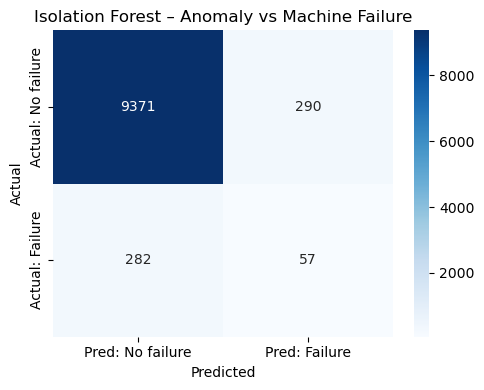

In [9]:
cm = confusion_matrix(y, y_anom)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Pred: No failure", "Pred: Failure"],
            yticklabels=["Actual: No failure", "Actual: Failure"])
plt.title("Isolation Forest – Anomaly vs Machine Failure")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.tight_layout()
plt.show()


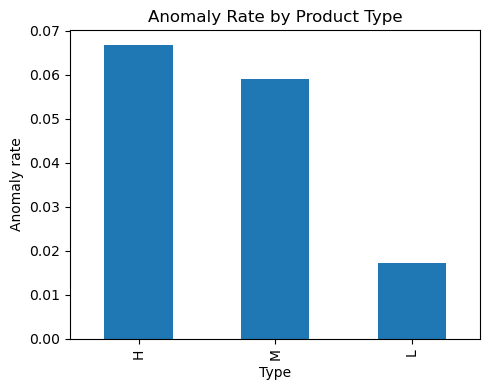

In [12]:
df_anom = df.copy()
df_anom["anomaly"] = y_anom

anomaly_rate_by_type = df_anom.groupby("Type")["anomaly"].mean().sort_values(ascending=False)
anomaly_rate_by_type

plt.figure(figsize=(5,4))
anomaly_rate_by_type.plot(kind="bar")
plt.ylabel("Anomaly rate")
plt.title("Anomaly Rate by Product Type")
plt.tight_layout()
plt.show()
